# DESIGNING CLOSED LOOP SYSTEMS

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

This notebook describes the proportional, integral, and differential controllers.

# Preliminaries

In [1]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import control
import controlSBML as ctl
from IPython.display import HTML, Math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

In [2]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)

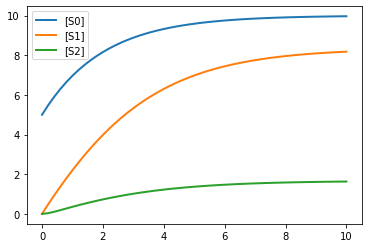

In [3]:
MODEL = """
-> S0; 5
S0 -> S1; k0*S0
S1 -> S2; k1*S1
S2 -> S1; k2*S2
S2 -> ; k3*S2

k0 = 0.5
k1 = 1
k2 = 2
k3 = 3
S0 = 5
S1 = 0
S2 = 0
"""
RR = te.loada(MODEL)
RR.simulate(0, 10)
RR.plot()

# Calculating symbolic eigenvalues

In [4]:
k0, k1, k2, k3, S1, S2, S0 = sympy.symbols("k0, k1, k2, k3, S1, S2, S0")

In [5]:
A = sympy.Matrix([[-k1, k2], [k1, -k2-k3]])
A

Matrix([
[-k1,       k2],
[ k1, -k2 - k3]])

In [6]:
eigenvalues = list(A.eigenvals().keys())
eigenvalues[1].simplify()

-k1/2 - k2/2 - k3/2 + sqrt(k1**2 + 2*k1*k2 - 2*k1*k3 + k2**2 + 2*k2*k3 + k3**2)/2

In [7]:
sympy.expand((k1 + k2 + k3)**2)

k1**2 + 2*k1*k2 + 2*k1*k3 + k2**2 + 2*k2*k3 + k3**2

In [8]:
expr1 = -(k1 +k2 + k3) + sympy.sqrt( (k1 + k2 +k3)**2 - 4*(k1*(k3-k2)))

In [9]:
sympy.N(expr1.subs({k1: 1, k2: 2, k3: 3}))

-0.343145750507620

In [10]:
expr2 = -(k1 +k2 + k3) - sympy.sqrt( (k1 + k2 +k3)**2 - 4*(k1*(k3-k2)))
sympy.N(expr2.subs({k1: 1, k2: 2, k3: 3}))

-11.6568542494924

# Full State Feedback

## Full State Controller

In [32]:
def makeController(name, kp_vec):
    """
    Creates a full state feedback controller.
    
    Parameters
    ----------
    name: str
        Name of the system
    kp_vec: list-float
    
    Returns
    -------
    control.NonlinearIOSystem
    """
    kp_vec = np.array(kp_vec)
    def outfcn(_, __, u_vec, ___):
        # u_vec: list-float - vector of internal state deviations
        output = kp_vec.dot(np.array(u_vec))
        return output
    #
    return control.NonlinearIOSystem(
        None, outfcn, inputs=['in1', 'in2'], outputs=['out'],
        name=name)

# Tests
kp_vec = [1, 2]
controller = makeController("controller", kp_vec=kp_vec)
times = [0, 1, 2, 3, 4]
U = np.array(list(zip(times, times)))
U = U.transpose()
result = control.input_output_response(controller, T=times, U=U)
assert(len(result.y[0]) == len(times))
assert(result.y[0][1] == 3)
print("OK!")

OK!


## Network

In [49]:
# Create elements
ctlsb = ctl.ControlSBML(MODEL, input_names=["S0"], output_names=["S1", "S2"])
system = ctlsb.makeNonlinearIOSystem("system")
#
controller = makeController("controller", [10, 10])
factory = ctl.IOSystemFactory()
adder_S1 = factory.makeAdder("adder_S1")
adder_S2 = factory.makeAdder("adder_S2")

In [50]:
# Create the closed loop system with a disturbance input.
closed_loop = control.interconnect(
  [adder_S1, adder_S2, system, controller ], 
  connections=[
    ['adder_S1.in1', '-system.S1'],    
    ['adder_S2.in1', '-system.S2'], 
    ['controller.in1', 'adder_S1.out'],    
    ['controller.in2', 'adder_S2.out'], 
    ["system.S0", "controller.out"],   
  ],
  inplist=["adder_S1.in2", "adder_S2.in2"],
  outlist = ["controller.out", "system.S1", "system.S2"],
)

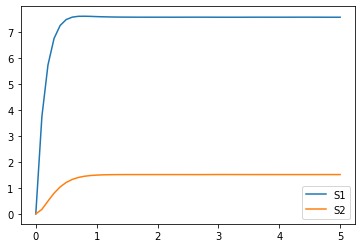

In [52]:
X0 = ctl.makeStateVector(closed_loop)
times = ctl.makeSimulationTimes(end_time=5, points_per_time=10)
REF = [5, 5]
U = np.array([REF for _ in range(len(times))])
U = np.transpose(U)
result = control.input_output_response(closed_loop, T=times, U=U, X0=X0)
plt.plot(result.t.flatten(), result.outputs[1].flatten())
plt.plot(result.t.flatten(), result.outputs[2].flatten())
plt.legend(["S1", "S2"])

In [36]:
factory.report()

,adder_S2.in1,adder_S2.in2,adder_S2.out,adder_S1.in1,adder_S1.in2,adder_S1.out
time,,,,,,
0.000,0.000000,13.0,13.000000,0.000000,12.0,12.000000
0.002,-0.000022,13.0,12.999978,-0.030960,12.0,11.969040
0.003,-0.000067,13.0,12.999933,-0.040891,12.0,11.959109
0.007,-0.000382,13.0,12.999618,-0.099280,12.0,11.900720
0.008,-0.000483,13.0,12.999517,-0.110244,12.0,11.889756
...,...,...,...,...,...,...
19.710,-2.085029,13.0,10.914971,-10.416012,12.0,1.583988
19.746,-2.084963,13.0,10.915037,-10.416038,12.0,1.583962
19.927,-2.081852,13.0,10.918148,-10.417238,12.0,1.582762
